<a href="https://colab.research.google.com/github/allansdefreitas/unsupervised-learning/blob/main/EXP_questao_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Read:
https://sites.google.com/site/dataclusteringalgorithms/fuzzy-c-means-clustering-algorithm
https://towardsdatascience.com/fuzzy-c-means-clustering-with-python-f4908c714081
https://github.com/theimageprocessingguy/Fuzzy-C-Means-Python


https://pyclustering.github.io/docs/0.10.1/html/
https://scikit-fuzzy.github.io/scikit-fuzzy/
https://www.youtube.com/watch?v=nGWmgHxIoPk&ab_channel=%E6%9D%8E%E6%94%BF%E8%BB%92
https://www.youtube.com/watch?v=zEYxTGDYWYI

"""

'Read:\nhttps://sites.google.com/site/dataclusteringalgorithms/fuzzy-c-means-clustering-algorithm\nhttps://towardsdatascience.com/fuzzy-c-means-clustering-with-python-f4908c714081\nhttps://github.com/theimageprocessingguy/Fuzzy-C-Means-Python\n\n\nhttps://pyclustering.github.io/docs/0.10.1/html/\nhttps://scikit-fuzzy.github.io/scikit-fuzzy/\nhttps://www.youtube.com/watch?v=nGWmgHxIoPk&ab_channel=%E6%9D%8E%E6%94%BF%E8%BB%92\nhttps://www.youtube.com/watch?v=zEYxTGDYWYI\n\n'

In [2]:
EXPERIMENT_MODE = False

In [3]:
from google.colab import drive

if EXPERIMENT_MODE:
  drive.mount('/content/drive')

In [4]:
!pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894073 sha256=b5bd1e21b8da1d676b7f27abbfcc7a4fdb45736fdbf47bae1cb05b54df015383
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [5]:
#imports
import numpy as np
import pandas as pd

import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler
from numpy import savetxt
from numpy import loadtxt
import os
from scipy.spatial.distance import cdist


from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Funções

In [6]:
def preprocess_dataset(dataframe):

    #pre-processing of dataset
    scaler = StandardScaler()
    data = scaler.fit_transform(dataframe.values)

    return data


#Modified partition coefficient e partition entropy --------------################

#close to 1 values are better
#A value of 0 indicates complete fuzziness, where data points have equal membership to all clusters
#A value of 1 indicates crisp or hard clustering, where data points have membership to only one cluster.
def calculate_mpc(membership_matrix):
    """
    Apply T operation over the U matrix before later operations, then after that
    the shape of U matrix will be (n_clusters, n_samples).

    Calculates the Modified Partition Coefficient (MPC) for Fuzzy C-Means clustering.

    Parameters:
        membership_matrix (numpy.ndarray): Membership matrix of shape (n_samples, n_clusters).

    Returns:
        float: Modified Partition Coefficient value.

    """
    membership_matrix = membership_matrix.T #after we will have  (n_clusters, n_samples).

    max_memberships = np.max(membership_matrix, axis=1)
    sum_memberships = np.sum(membership_matrix, axis=1)

    mpc = np.mean(max_memberships / sum_memberships)

    return mpc

#close to 0 values are better
#A value of 0 indicates a crisp or hard clustering, where data points have membership only to one cluster and there is no uncertainty
#higher values indicates uncertainty and fuzziness in the clustering, with data points having more equal memberships across multiple clusters.
def calculate_partition_entropy(membership_matrix):
    """
    Apply T operation over the U matrix BEFORE later operations, so after that
    the shape of U matrix will be (n_clusters, n_samples).

    Calculates the Partition Entropy for Fuzzy C-Means clustering.

    Parameters:
        membership_matrix (numpy.ndarray): Membership matrix of shape (n_samples, n_clusters).

    Returns:
        float: Partition Entropy value.
    """
    membership_matrix = membership_matrix.T #after we will have  (n_clusters, n_samples).
    n_samples, n_clusters = membership_matrix.shape

    entropy = 0.0

    for i in range(n_samples):
        for j in range(n_clusters):
            if membership_matrix[i, j] > 0:
                entropy -= membership_matrix[i, j] * np.log2(membership_matrix[i, j])

    partition_entropy = entropy / n_samples

    return partition_entropy


"""## Em cada dataset execute o algoritmo FCM com a distância de City-Block 50 vezes para obter
uma partição fuzzy em 7 grupos e selecione o melhor resultado segundo a função objetivo."""
def get_best_partition(data, n_clusters_C, m, error_e, maxiter_T, distance_metric = 'cityblock', times_to_run=50):

    best_objective_value = 99999999999.9
    best_results = 0

    for i in range(times_to_run):

      cntr, u, u0, d, jm, p, fpc = skfuzzy_fcm(data, n_clusters_C, m, error_e, maxiter_T, distance_metric)

      centroids, membership_matrix_U, iterations, objective_functions = cntr, u, p, jm

      objective_value = jm[-1] #the last element is the last and best objective function

      if(objective_value < best_objective_value):

        best_objective_value = objective_value

        best_results = centroids, membership_matrix_U, iterations, best_objective_value

    return best_results

#ok
def fuzzy_to_crisp_partition(membership_matrix):
    """
    Converts a fuzzy partition into a crisp partition to be
    in a one-hot-enconding format.

    Parameters:
        membership_matrix (numpy.ndarray): Membership matrix of shape (n_clusters, n_samples).

    Returns:
        numpy.ndarray: CRISP/hard partition of shape (n_clusters, n_samples).
    """

    U_crisp_matrix = np.zeros_like(membership_matrix)

    labels_for_crisp = np.argmax(membership_matrix, axis=0)

    num_elements = membership_matrix.shape[1] #the number of elements of data

    for i in range(num_elements):
      label_one_hot = labels_for_crisp[i] #position of cluster that will be activated in one-hot-encoding
      U_crisp_matrix[label_one_hot][i] = 1


    return U_crisp_matrix



def get_labels_from_crisp_or_fuzzy(U_matrix):

  """
  Given U crisp or fuzzy matrix, returns the labels
  """

  labels = np.argmax(U_matrix, axis=0)

  return labels

def pie_plot_crisp_partition(U_crisp_matrix, label_names, filename):
  """

  create, show and save a pie plot chart based on crisp matrix and its
  cluster's labels passed as argument of function

  """

  labels_crisp = get_labels_from_crisp_or_fuzzy(U_crisp_matrix)

  #get the quantity/size of ocurrences of each cluster
  _, sizes = np.unique(labels_crisp, return_counts=True)

  fig, ax = plt.subplots()
  ax.pie(sizes, labels=label_names)

  complete_filename = filename + '.png'
  plt.savefig(complete_filename)


def calculate_ari(clustering_1, clustering_2):

  # Calculate ARI
  ari = adjusted_rand_score(clustering_1, clustering_2)

  return ari


def plot_scatter_two_features(data, labels, indexColumnA, indexColumnB, save_fig=True, dataset_name='dataset'):

  # Show 3-cluster model
  fig2, ax2 = plt.subplots()
  ax2.set_title('data')
  for j in range(7):
      ax2.plot(data[indexColumnA, labels == j],
              data[indexColumnB, labels == j], 'o',
              label='cluster ' + str(j))
  ax2.legend()

  if save_fig:
    filename = dataset_name  + '_feat_' + str(indexColumnA) + '_' + str(indexColumnB)
    complete_filename = filename + '.png'
    plt.savefig(complete_filename)

"""
Given a dataset, its labels and features indexes, this function prints (and save, if you want)
a figure in 3D with the clusters in its own colors and the properly features names

"""
def plot_scatter_three_features(data, labels, fetures_indexes_list, save_fig=False, dataset_name='dataset'):

  import matplotlib.pyplot as plt
  import matplotlib.cm as cm

  feature_x_index = fetures_indexes_list[0]
  feature_y_index = fetures_indexes_list[1]
  feature_z_index = fetures_indexes_list[2]

  feature_x_label = dataset_2_features_labels[feature_x_index]
  feature_y_label = dataset_2_features_labels[feature_y_index]
  feature_z_label = dataset_2_features_labels[feature_z_index]

  fig_title = dataset_name + ': ' + feature_x_label + ', '  + feature_y_label + ' e ' +  feature_z_label

  fig = plt.figure()
  fig.set_figheight(12)
  fig.set_figwidth(8)
  ax = fig.add_subplot(111, projection='3d')
  #cm.rainbow, cm.jet
  ax.scatter(data[:,feature_x_index], data[:,feature_y_index], data[:,feature_z_index], c=labels, cmap=cm.rainbow )
  ax.set_title(fig_title)

  ax.set_xlabel(feature_x_label, fontsize='12')
  ax.set_ylabel(feature_y_label, fontsize='12')
  ax.set_zlabel(feature_z_label, fontsize='12')

  if save_fig:
    filename = fig_title
    complete_filename = filename + '.png'
    plt.savefig(complete_filename)

  plt.show()



def plot_confusion_matrix(labels_a_priori, labels_posteriori, labels_clusters_names, save_fig=True, filename=None, dataset_name='dataset', plot_title=None, show_plot=True):

  #from: https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
  #https://scikit-learn.org/stable/modules/clustering.html
  #https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

  if plot_title is None:
    title='Matriz de confusão' + ' ' + dataset_name
  else:
    title = plot_title

  #for IMAGE SEGMENTATION DATASET
  # Creating  a confusion matrix,which compares the y_test and y_pred

  cm = confusion_matrix(labels_a_priori, labels_posteriori)
  # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
  mylist = list(labels_clusters_names)
  cm_df = pd.DataFrame(cm,
                      index = list(labels_clusters_names),
                      columns = list(labels_clusters_names))
  #Plotting the confusion matrix
  plt.figure(figsize=(12,10))
  sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
  plt.title( title )
  plt.ylabel('Clusters a priori (actual)')
  plt.xlabel('Clusters a posteriori (predicted)')

  if save_fig:
    if filename is None:
      filename =dataset_name + '_confusion_matrix'

    #use the filename received from function
    complete_filename = filename + '.png'
    plt.savefig(complete_filename)


  if show_plot:
    plt.show()
  else:
    plt.close()

#from [0,1]. 1 is better
#VERIFY
def calculate_f_measureOLD(partition1, partition2):
    tp = sum(1 for i in partition1 for j in partition2 if i == j)  # Conta os verdadeiros positivos
    fp = len(partition1) - tp  # Calcula os falsos positivos
    fn = len(partition2) - tp  # Calcula os falsos negativos

    f_measure = (2 * tp) / (2 * tp + fp + fn)
    return f_measure

def calculate_f_measure(partition1, partition2):

    f_measure = f1_score(partition1, partition2, average='micro')
    return f_measure

#from:
#https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html
def skfuzzy_fcm(data, n_clusters_C, m,  error_e=0.000001, maxiter_T=100, distance_metric='cityblock'):

  #É preciso obter a matriz transposta, já que o método espera uma
  #matriz de shape (S, N), i.e. (num_grupos, num_elementos)
  data = data.T

  # Perform Fuzzy C-means clustering
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
      data, #IT WAS: data_city_block.T. Is this right?
      n_clusters_C,
      m=m,
      error=error_e,
      maxiter=maxiter_T,
      metric=distance_metric
  )

  # The 'u' matrix contains the fuzzy membership values for each data point
  return  cntr, u, u0, d, jm, p, fpc

In [7]:
"""
Compare metrics in which higher values means better results
"""
def compare_metrics_higher_better(a, b, partition_a, partition_b, metric_name):

  if(a > b):
    print(partition_a + ' com melhor ' + metric_name)
  elif(a < b):
    print(partition_b + ' com melhor ' + metric_name)
  else:
    print('resultados iguais para ' + metric_name)


"""
Compare metrics in which LOWER values means better results
"""
def compare_metrics_lower_better(a, b, partition_a, partition_b, metric_name):

  if(a < b):
    print(partition_a + ' com melhor ' + metric_name)
  elif(a > b):
    print(partition_b + ' com melhor ' + metric_name)
  else:
    print('resultados iguais para ' + metric_name)


def copyfile(file, path_source, path_dest):
  import shutil
  import os

  full_source_path_file = os.path.join(path_source, file)
  source_path = full_source_path_file

  #get destination path
  full_dest_path_file = os.path.join(path_dest, file)
  destination_path = full_dest_path_file

  shutil.copy(source_path, destination_path)

In [8]:
"""
save datasets to csv files
"""
def save_U_and_centroids_matrix_csv(membership_matrix_U, centroids, m=''):

  # save i-th dataset to csv file
  # filename = 'dataset_'+ str(i + 1) + '_U_matrix_m_' + str(m)
  filename = 'dataset_'+ str(i + 1) + '_U_matrix'
  savetxt(filename + '.csv', membership_matrix_U, delimiter=',')

  # save i-th centroids to csv file
  filename = 'dataset_'+ str(i + 1) + '_centroids_matrix'
  # filename = 'dataset_'+ str(i + 1) + '_centroids_matrix_m_' + str(m)
  savetxt(filename + '.csv', centroids, delimiter=',')

In [9]:
def plot_centroids_as_table(centroids, dataset_feature_labels, save_fig=False, filename=None, dataset_name='dataset', plot_title=None, show_plot=True):

  import numpy as np
  from matplotlib import pyplot as plt

  plt.rcParams["figure.figsize"] = [30.00, 5.50]
  plt.rcParams["figure.autolayout"] = True

  fig, axs = plt.subplots(1, 1)

  columns = tuple(dataset_feature_labels)
  axs.axis('tight')
  axs.axis('off')
  the_table = axs.table(cellText=centroids, colLabels=columns, loc='center', cellLoc='center')


  if plot_title is None:
    title='Centroids (protótipos): ")' + ' ' + dataset_name
  else:
    title = plot_title

  axs.set_title(title,
          fontweight ="bold")

  if save_fig:
    if filename is None:
      filename = dataset_name + '_centroids'

    complete_filename = filename + '.png'
    plt.savefig(complete_filename)

  if show_plot:
    plt.show()
  else:
    plt.close(fig)

In [10]:
"""
To save U or centroids matrix

"""
def save_matrix_csv(matrix, filename):

  # save i-th centroids to csv file
  savetxt(filename + '.csv', matrix, delimiter=',')

In [11]:
"""
To load U or centroids matrix.
Return the matrix loaded.

"""
def load_matrix_csv(filename):

  # get the matrix from csv file
  matrix = loadtxt(filename + '.csv', delimiter=',')

  return matrix

In [12]:
#!cp -r '/content' '/content/drive/MyDrive/Projeto AM Francisco/resultados_questao_1' #no

def save_result_files_drive(path_content_drive, path_drive_results_folder, new_folder_name=''):

  import shutil
  import os


  path_drive_results_folder = os.path.join(path_drive_results_folder, new_folder_name)
  # os.mkdir(path_drive_results_folder)

  for file in os.listdir(path_content_drive):
      if file.endswith(".png"):
        print(file)
        copyfile(file, path_content_drive, path_drive_results_folder)

      elif file.endswith(".csv"):
        print(file)
        copyfile(file, path_content_drive, path_drive_results_folder)



"""
Shortcut for function. To clear the colab environment.
"""

def clear():
  clear_content_result_files('/content', log=False)

"""
Clear the drive local environment. Run it before an EXPERIMENT
"""
def clear_content_result_files(path_content_drive, log=True):

  import shutil
  import os

  for file in os.listdir(path_content_drive):
      if file.endswith(".png"):
        full_file_path = os.path.join(path_content_drive, file)
        os.remove(full_file_path)

        if log:
          print(file + ' removed')

      elif file.endswith(".csv"):

        full_file_path = os.path.join(path_content_drive, file)
        os.remove(full_file_path)

        if log:
          print(file + ' removed')

In [13]:
"""
a matrix de confusão
da partição crisp versus a partição a priori

"""
def run_centroids_confusion_matrix_vs_a_priori(n_clusters_C, m_list, error_e, maxiter_T, distance_metric='cityblock', times=50, save_fig=False, show_plot=False):

  best_results = 0
  datasets = [X_dataset_1, X_dataset_2, X_dataset_3]
  best_results = []

  print("PROTÓTIPOS E A MATRIX DE CONFUSÃO DA PARTIÇÃO CRISP VERSUS A PARTIÇÃO A PRIORI (ITENS I E II) ######################################")
  print("\n\n ")

  for i in range(NUMBER_OF_DATASETS):

    for m in m_list:

      dataset_i = datasets[i]
      dataset_name = datasets_names[i]

      centroids, U, iter, objective_value = get_best_partition(dataset_i, n_clusters_C, m, error_e, maxiter_T, distance_metric = distance_metric, times_to_run=times)

      mpc = calculate_mpc(U)
      pe = calculate_partition_entropy(U)

      crisp = fuzzy_to_crisp_partition(U)

      labels_posteriori = get_labels_from_crisp_or_fuzzy(crisp)

      #put it together with the true labels (labels_a_priori) to calculate the ARI
      ari = calculate_ari(labels_posteriori, labels_a_priori)
      f_measure = calculate_f_measure(labels_posteriori, labels_a_priori)


      print(dataset_name + ' m= ' + str(m) + ' | obj func= %.2f' % round(objective_value,2) + ' |'
      + ' FUZZY MPC=  %.2f' % round(mpc,2) + ' | '
      + ' FUZZY PE= %.2f' % round(pe, 2) + ' | '
      + ' CRISP ARI= %.2f' % round(ari, 2) + ' | '
      + ' CRISP F-measure= %.2f' % round(f_measure, 2) )

      #print("\n")

      #save U, centroids and crisp to csv files :)
      #U
      filename = dataset_name + '_m=' + str(m) + '_U_matrix'
      save_matrix_csv(U, filename)

      #centroids
      filename = dataset_name + '_m=' + str(m) + '_centroids'
      save_matrix_csv(centroids, filename)

      #crisp
      filename = dataset_name + '_m=' + str(m) + '_crisp_partition'
      save_matrix_csv(crisp, filename)


      dataset_feature_labels = datasets_features_labels[i]

      title_centroids = dataset_name  + '_m=' + str(m) + ' Centroids'
      print(title_centroids)
      plot_centroids_as_table(centroids, dataset_feature_labels, save_fig=save_fig, filename=title_centroids,
                              dataset_name=dataset_name, plot_title=title_centroids, show_plot=show_plot)
      #print("\n\n")

      title_cm = "Confusion matrix: " + dataset_name + '_m=' + str(m) + ' vs a priori'
      print(title_cm)
      plot_confusion_matrix(labels_a_priori, labels_posteriori, labels_clusters_names, save_fig=save_fig,
                            filename=title_cm, dataset_name=dataset_name, plot_title=title_cm, show_plot=show_plot)
      #print("\n\n")

      print("\n")

    print("\n==========================================\n")


In [14]:
"""
III) A MATRIX DE CONFUSÃO DE UMA PARTIÇÃO CRISP VERSUS A OUTRA;
"""
def run_confusion_matrix_crisp_vs_crisp(ds_list, m_list, save_fig=True, show_plot=True):


  print("III) A MATRIX DE CONFUSÃO DE UMA PARTIÇÃO CRISP VERSUS A OUTRA; ######################################")
  print("\n\n ")

  counter = 0

  for i_ds in range(len(ds_list)):
    for j_m in range(len(m_list)):

        for k_ds in range(len(ds_list)):
          for l_m in range(len(m_list)):

            ds1 = datasets_names[i_ds]
            ds2 = datasets_names[i_ds]

            m1 = m_list[j_m]
            m2 = m_list[l_m]

            if ds1 == ds2 and m1 == m2:
              continue
            else:
              counter +=1
              part_a = ds1 + ' m=' + str(m1)
              part_b = ds2 + ' m=' + str(m2)
              comparison_title = part_a + ' VS ' + part_b
              print(comparison_title, "\n")

            #print confusion matrix
            #get crisp1 and crisp2 from files
            #crisp 1
            filename_crisp_1 = ds1 + '_m=' +str(m1) + '_crisp_partition'
            crisp1 = load_matrix_csv(filename=filename_crisp_1)

            #get labels crisp1
            labels_crisp1 = get_labels_from_crisp_or_fuzzy(crisp1)

            #crisp 2
            filename_crisp_2 = ds2 + '_m=' +str(m2) + '_crisp_partition'
            crisp2 = load_matrix_csv(filename=filename_crisp_2)

            #get labels crisp2
            labels_crisp2 = get_labels_from_crisp_or_fuzzy(crisp2)

            #plot the confusion matrix between crisp1 and crisp2
            plot_confusion_matrix(labels_crisp1, labels_crisp2, labels_clusters_names, save_fig=save_fig,
                                  filename=comparison_title, dataset_name=None, plot_title=comparison_title, show_plot=show_plot)

            print("\n")

    print('\n\n')

  print(counter)

In [15]:
clear()

In [16]:
"""
a matrix de confusão
da partição crisp versus a partição a priori

"""
def run_experiment_fcm(datasets, n_clusters_C, m_list, error_e, maxiter_T, distance_metric='cityblock', times=50):

  best_results = []

  results_obj_func_matrix = np.zeros((len(datasets), len(m_list)))

  print("Em cada dataset execute o algoritmo FCM com a distância de City-Block 50 vezes para obter uma partição fuzzy em 7 grupos"
      + "e selecione o melhor resultado segundo a função objetivo ")

  print("\n\n ")

  for i in range(NUMBER_OF_DATASETS):

    for j in range(len(m_list)):

      m = m_list[j]
      dataset_i = datasets[i]
      dataset_name = datasets_names[i]

      centroids, U, iter, objective_value = get_best_partition(dataset_i, n_clusters_C, m, error_e, maxiter_T, distance_metric = distance_metric, times_to_run=times)
      results_obj_func_matrix[i][j] = objective_value

      mpc = calculate_mpc(U)
      pe = calculate_partition_entropy(U)

      crisp = fuzzy_to_crisp_partition(U)

      labels_posteriori = get_labels_from_crisp_or_fuzzy(crisp)

      #put it together with the true labels (labels_a_priori) to calculate the ARI
      ari = calculate_ari(labels_posteriori, labels_a_priori)
      f_measure = calculate_f_measure(labels_posteriori, labels_a_priori)


      print(dataset_name + ' m= ' + str(m) + ' | obj func= %.2f' % round(objective_value,2) + ' |'
      + ' FUZZY MPC=  %.2f' % round(mpc,2) + ' | '
      + ' FUZZY PE= %.2f' % round(pe, 2) + ' | '
      + ' CRISP ARI= %.2f' % round(ari, 2) + ' | '
      + ' CRISP F-measure= %.2f' % round(f_measure, 2) )

      #print("\n")

      #save U, centroids and crisp to csv files :)
      #U
      filename = dataset_name + '_m=' + str(m) + '_U_matrix'
      save_matrix_csv(U, filename)

      #centroids
      filename = dataset_name + '_m=' + str(m) + '_centroids'
      save_matrix_csv(centroids, filename)

      #crisp
      filename = dataset_name + '_m=' + str(m) + '_crisp_partition'
      save_matrix_csv(crisp, filename)

      #print("\n\n")

      print("\n")

    print("\n==========================================\n")

  df_results = pd.DataFrame(results_obj_func_matrix, columns = [m_list[0],m_list[1],m_list[2]], index = [datasets_names[0], datasets_names[1], datasets_names[2]])

  return results_obj_func_matrix, df_results

In [17]:
"""
III) A MATRIX DE CONFUSÃO DE UMA PARTIÇÃO CRISP VERSUS A OUTRA;
"""
def run_show_confusion_matrix_crisp_vs_crisp(best_part_crisp, save_fig=True, show_plot=True):


  for i in range(NUMBER_OF_DATASETS):
    for j in  range(NUMBER_OF_DATASETS):

      if j < i:
        continue
      if i == j:
        continue


      best_result_pos = arr_best_indexes[i]
      m1 = m_list[best_result_pos]
      m2 = m_list[best_result_pos]

      part_a = datasets_names[i] + ' m=' + str(m1)
      part_b = datasets_names[j] + ' m=' + str(m2)

      comparison_title = part_a + ' VS ' + part_b

      #crisp 1
      crisp1 = best_part_crisp[i]
      labels_crisp1 = get_labels_from_crisp_or_fuzzy(crisp1)

      #crisp 2
      crisp2 = best_part_crisp[j]

      #get labels crisp2
      labels_crisp2 = get_labels_from_crisp_or_fuzzy(crisp2)

      #plot the confusion matrix between crisp1 and crisp2
      plot_confusion_matrix(labels_crisp1, labels_crisp2, labels_clusters_names, save_fig=save_fig,
                            filename=comparison_title, dataset_name=None, plot_title=comparison_title, show_plot=show_plot)

      print("\n")


In [18]:
"""
A MATRIX DE CONFUSÃO DA PARTIÇÃO CRISP VERSUS A PARTIÇÃO A PRIORI (ITEM II)

"""
def run_show_confusion_matrix_vs_a_priori(save_fig=False, show_plot=False):

  print("A MATRIX DE CONFUSÃO DA PARTIÇÃO CRISP VERSUS A PARTIÇÃO A PRIORI ######################################")

  for i in range(NUMBER_OF_DATASETS):

    dataset_name = datasets_names[i]
    centroids = best_part_centroids[i]
    crisp = best_part_crisp[i]
    labels_posteriori = get_labels_from_crisp_or_fuzzy(crisp)

    dataset_feature_labels = datasets_features_labels[i]

    title_cm = "Confusion matrix: " + dataset_name + '_m=' + str(m) + ' vs a priori'
    print(title_cm)
    plot_confusion_matrix(labels_a_priori, labels_posteriori, labels_clusters_names, save_fig=save_fig,
                          filename=title_cm, dataset_name=dataset_name, plot_title=title_cm, show_plot=show_plot)
    #print("\n\n")

    print("\n")

# Preparação dos dados

In [19]:
"""
I. Considere os dados "Image Segmentation" do site uci machine learning
repository (https://archive.ics.uci.edu/ml/datasets/Image+Segmentation).

"""
#To be used in Google Drive to save result files properly
PATH_DRIVE_RESULTS_FOLDER='/content/drive/MyDrive/Projeto AM Francisco/resultados_questao_1'
PATH_CONTENT_DRIVE='/content'


NUMBER_OF_DATASETS = 3
datasets_names = ['Dataset 1 (shape)', 'Dataset 2 (RGB)', 'Dataset 3 (shape + RGB)']

PATH = 'https://raw.githubusercontent.com/allansdefreitas/unsupervised-learning/main/segmentation.data'
PATH2 = 'https://raw.githubusercontent.com/allansdefreitas/unsupervised-learning/main/segmentation.test'

dataset_original = pd.read_csv(PATH, sep=',')
dataset_original2 = pd.read_csv(PATH2, sep=',')

#concat datasets
frames = [dataset_original, dataset_original2]
dataset_original_with_indexes = pd.concat(frames)

dataset_without_indexes = dataset_original_with_indexes.reset_index(drop=True)

#obter os labels a priori
indexes = dataset_original_with_indexes.index
indexes_label = []

for i in indexes:
    indexes_label.append(i)

le = preprocessing.LabelEncoder()
labels_a_priori = le.fit_transform(indexes_label)

labels_clusters_names = ['0', '1', '2', '3', '4', '5', '6']

""" Considere 3 datasets: """
""" 1) primeiro considerando as variáveis 4 a 9 (shape) ----------"""

dataset_1 = dataset_without_indexes.iloc[:,3:9]

#get the labels of features: the labels of each att
dataset_1_features_labels = dataset_1.columns.values.tolist()

#pre-processing of dataset
X_dataset_1 = preprocess_dataset(dataset_1)


"""2) o segundo considerando as variaveis 10 a 19 (rgb) ----------"""
dataset_2 = dataset_without_indexes.iloc[:,9:19]

#get the labels of features: the labels of each att
dataset_2_features_labels = dataset_2.columns.values.tolist()

#pre-processing of dataset
X_dataset_2 = preprocess_dataset(dataset_2)

"""3) O terceiro considerando as variaveis 4 a 19 (shape + rgb) -------"""
dataset_3 = dataset_without_indexes.iloc[:,3:19]

#get the labels of features: the labels of each att
dataset_3_features_labels = dataset_3.columns.values.tolist()


#the features' labels of all three datasets
datasets_features_labels = [dataset_1_features_labels, dataset_2_features_labels, dataset_3_features_labels]

#pre-processing of dataset
X_dataset_3 = preprocess_dataset(dataset_3)

# Questão 1

## FCM 50x com distância de city-block. Selecionar melhores partições

In [20]:
datasets = [X_dataset_1, X_dataset_2, X_dataset_3]
n_clusters_C = 7
m_list = [1.1, 1.6, 2.0]
error_e = 0.000001 #10−6
maxiter_T = 100
distance_metric = 'cityblock'
times = 50 #50

#take a look
results_obj_func_matrix, df_results = run_experiment_fcm(datasets, n_clusters_C, m_list, error_e, maxiter_T, distance_metric='cityblock', times=times)

Em cada dataset execute o algoritmo FCM com a distância de City-Block 50 vezes para obter uma partição fuzzy em 7 grupose selecione o melhor resultado segundo a função objetivo 


 
Dataset 1 (shape) m= 1.1 | obj func= 6824.86 | FUZZY MPC=  1.00 |  FUZZY PE= 0.01 |  CRISP ARI= 0.01 |  CRISP F-measure= 0.16


Dataset 1 (shape) m= 1.6 | obj func= 5266.86 | FUZZY MPC=  0.92 |  FUZZY PE= 0.33 |  CRISP ARI= 0.03 |  CRISP F-measure= 0.14


Dataset 1 (shape) m= 2.0 | obj func= 3138.95 | FUZZY MPC=  0.83 |  FUZZY PE= 0.70 |  CRISP ARI= 0.05 |  CRISP F-measure= 0.18




Dataset 2 (RGB) m= 1.1 | obj func= 10855.80 | FUZZY MPC=  0.99 |  FUZZY PE= 0.04 |  CRISP ARI= 0.45 |  CRISP F-measure= 0.09


Dataset 2 (RGB) m= 1.6 | obj func= 9407.95 | FUZZY MPC=  0.89 |  FUZZY PE= 0.50 |  CRISP ARI= 0.45 |  CRISP F-measure= 0.14


Dataset 2 (RGB) m= 2.0 | obj func= 6730.38 | FUZZY MPC=  0.76 |  FUZZY PE= 1.11 |  CRISP ARI= 0.45 |  CRISP F-measure= 0.08




Dataset 3 (shape + RGB) m= 1.1 | obj func= 54342.21

### Resultados para cada partição e m

In [21]:
df_results

,1.1,1.6,2.0
Dataset 1 (shape),6824.859011,5266.857563,3138.945448
Dataset 2 (RGB),10855.800754,9407.945114,6730.381651
Dataset 3 (shape + RGB),54342.210990,39153.612607,23481.131140


In [22]:
#pegar esses melhores modelos
arr_best_indexes = np.argmin(results_obj_func_matrix, axis=1)
arr_best_indexes

best_part_U = []
best_part_centroids = []
best_part_crisp = []

for i in range(NUMBER_OF_DATASETS):
  best_result_pos = arr_best_indexes[i]
  m = m_list[best_result_pos]
  dataset_name = datasets_names[i]

  filename = dataset_name + '_m=' + str(m) + '_U_matrix'
  print(filename + " loaded")
  U = load_matrix_csv(filename)
  best_part_U.append(U)

  #centroids
  filename = dataset_name + '_m=' + str(m) + '_centroids'
  centroids = load_matrix_csv(filename)
  best_part_centroids.append(centroids)

  #crisp
  filename = dataset_name + '_m=' + str(m) + '_crisp_partition'
  crisp = load_matrix_csv(filename)
  best_part_crisp.append(crisp)

Dataset 1 (shape)_m=2.0_U_matrix loaded
Dataset 2 (RGB)_m=2.0_U_matrix loaded
Dataset 3 (shape + RGB)_m=2.0_U_matrix loaded


## MEDIR MPC e PE

In [23]:
#MEDIR MPC e PE
for i in range(NUMBER_OF_DATASETS):

  best_result_pos = arr_best_indexes[i]
  m = m_list[best_result_pos]

  dataset_name = datasets_names[i]
  U = best_part_U[i]
  crisp = best_part_crisp[i]

  mpc = calculate_mpc(U)
  pe = calculate_partition_entropy(U)

  print(dataset_name + '(FUZZY) m= ' + str(m) + ' |'
  + ' MPC=  %.2f' % round(mpc,2) + ' | '
  + ' PE= %.2f' % round(pe, 2))

Dataset 1 (shape)(FUZZY) m= 2.0 | MPC=  0.83 |  PE= 0.70
Dataset 2 (RGB)(FUZZY) m= 2.0 | MPC=  0.76 |  PE= 1.11
Dataset 3 (shape + RGB)(FUZZY) m= 2.0 | MPC=  0.61 |  PE= 1.68


## MEDIR ARI e F-MEASURE

In [24]:
list_crisp_ari = []
list_crisp_f_measure = []

rand_index_f_measures = []

#MEDIR ARI e F-MEASURE
for i in range(NUMBER_OF_DATASETS):

  dataset_name = datasets_names[i]
  crisp = best_part_crisp[i]

  labels_posteriori = get_labels_from_crisp_or_fuzzy(crisp)

  #put it together with the true labels (labels_a_priori) to calculate the ARI
  ari = calculate_ari(labels_posteriori, labels_a_priori)
  f_measure = calculate_f_measure(labels_posteriori, labels_a_priori)

  rand_index_f_measures.append( [ari, f_measure] )

  print(dataset_name + '(CRISP) m= ' + str(m) + ' |'
    + ' ARI= %.2f' % round(ari, 2) + ' | '
    + ' F-measure= %.2f' % round(f_measure, 2) )

Dataset 1 (shape)(CRISP) m= 2.0 | ARI= 0.05 |  F-measure= 0.18
Dataset 2 (RGB)(CRISP) m= 2.0 | ARI= 0.45 |  F-measure= 0.08
Dataset 3 (shape + RGB)(CRISP) m= 2.0 | ARI= 0.51 |  F-measure= 0.02


## CRISP DUAS A DUAS RAND e F-1

In [25]:
#CRISP DUAS A DUAS RAND E F-1
# dataset_1 e dataset_2 -----------------------------------------------

partition_a = 'dataset_1'
partition_b = 'dataset_2'


#comparando Rand Index
metric_name = 'Rand Index'

print('Comparing ', partition_a ,  ' e ', partition_b, "--------\n")

ari_a =  rand_index_f_measures[0][0]
ari_b =  rand_index_f_measures[1][0]

print(metric_name + ': ', str(ari_a) +' e ' + str(ari_b))

compare_metrics_higher_better(ari_a, ari_b, partition_a, partition_b, metric_name)


#comparando F-measure
metric_name = 'F-measure'
f1_a =  rand_index_f_measures[0][1]
f1_b =  rand_index_f_measures[1][1]

print(metric_name + ': ', str(f1_a) + ' e ' + str(f1_b) )
compare_metrics_higher_better(f1_a, f1_b, partition_a, partition_b, metric_name)

print("\n\n")

# dataset_1 e dataset_3 -----------------------------------------------
partition_a = 'dataset_1'
partition_b = 'dataset_3'

#comparando Rand Index
metric_name = 'Rand Index'

print('Comparing ', partition_a ,  ' e ', partition_b, "--------\n")

ari_a =  rand_index_f_measures[0][0]
ari_b =  rand_index_f_measures[2][0]

print(metric_name + ': ', str(ari_a) +' e ' + str(ari_b))

compare_metrics_higher_better(ari_a, ari_b, partition_a, partition_b, metric_name)


#comparando F-measure
metric_name = 'F-measure'
f1_a =  rand_index_f_measures[0][1]
f1_b =  rand_index_f_measures[2][1]

print(metric_name + ': ', str(f1_a) + ' e ' + str(f1_b) )
compare_metrics_higher_better(f1_a, f1_b, partition_a, partition_b, metric_name)

print("\n\n")
# dataset_2 e dataset_3 -----------------------------------------------
partition_a = 'dataset_2'
partition_b = 'dataset_3'

#comparando Rand Index
metric_name = 'Rand Index'
print('Comparing ', partition_a ,  ' e ', partition_b, "--------\n")

ari_a =  rand_index_f_measures[1][0]
ari_b =  rand_index_f_measures[2][0]

print(metric_name + ': ', str(ari_a) +' e ' + str(ari_b))

compare_metrics_higher_better(ari_a, ari_b, partition_a, partition_b, metric_name)

#comparando F-measure
metric_name = 'F-measure'
f1_a =  rand_index_f_measures[1][1]
f1_b =  rand_index_f_measures[2][1]

print(metric_name + ': ', str(f1_a) + ' e ' + str(f1_b) )
compare_metrics_higher_better(f1_a, f1_b, partition_a, partition_b, metric_name)


Comparing  dataset_1  e  dataset_2 --------

Rand Index:  0.046775052548538094 e 0.4515147581710991
dataset_2 com melhor Rand Index
F-measure:  0.18354978354978355 e 0.08095238095238096
dataset_1 com melhor F-measure



Comparing  dataset_1  e  dataset_3 --------

Rand Index:  0.046775052548538094 e 0.5140181730019551
dataset_3 com melhor Rand Index
F-measure:  0.18354978354978355 e 0.019913419913419914
dataset_1 com melhor F-measure



Comparing  dataset_2  e  dataset_3 --------

Rand Index:  0.4515147581710991 e 0.5140181730019551
dataset_3 com melhor Rand Index
F-measure:  0.08095238095238096 e 0.019913419913419914
dataset_2 com melhor F-measure


## PROTÓTIPOS

In [26]:
"""
PROTÓTIPOS

"""
def run_show_centroids(save_fig=False, show_plot=False):

  print("PROTÓTIPOS ######################################")

  for i in range(NUMBER_OF_DATASETS):

    centroids = best_part_centroids[i]

    dataset_feature_labels = datasets_features_labels[i]

    title_centroids = dataset_name  + '_m=' + str(m) + ' centroids'
    print(title_centroids)
    plot_centroids_as_table(centroids, dataset_feature_labels, save_fig=save_fig, filename=title_centroids,
                            dataset_name=dataset_name, plot_title=title_centroids, show_plot=show_plot)
    #print("\n\n")

    print("\n")

PROTÓTIPOS ######################################
Dataset 3 (shape + RGB)_m=2.0 centroids


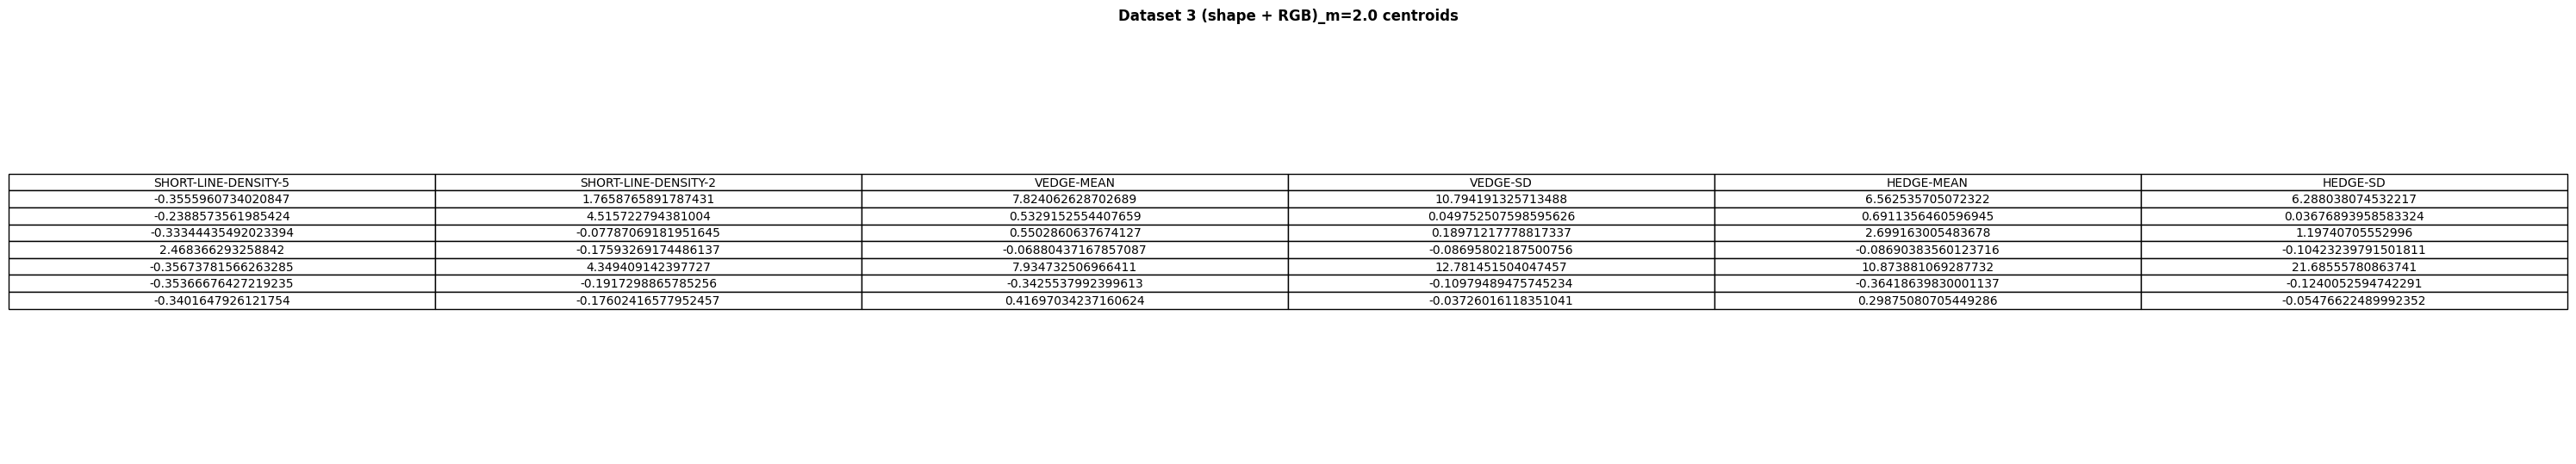



Dataset 3 (shape + RGB)_m=2.0 centroids


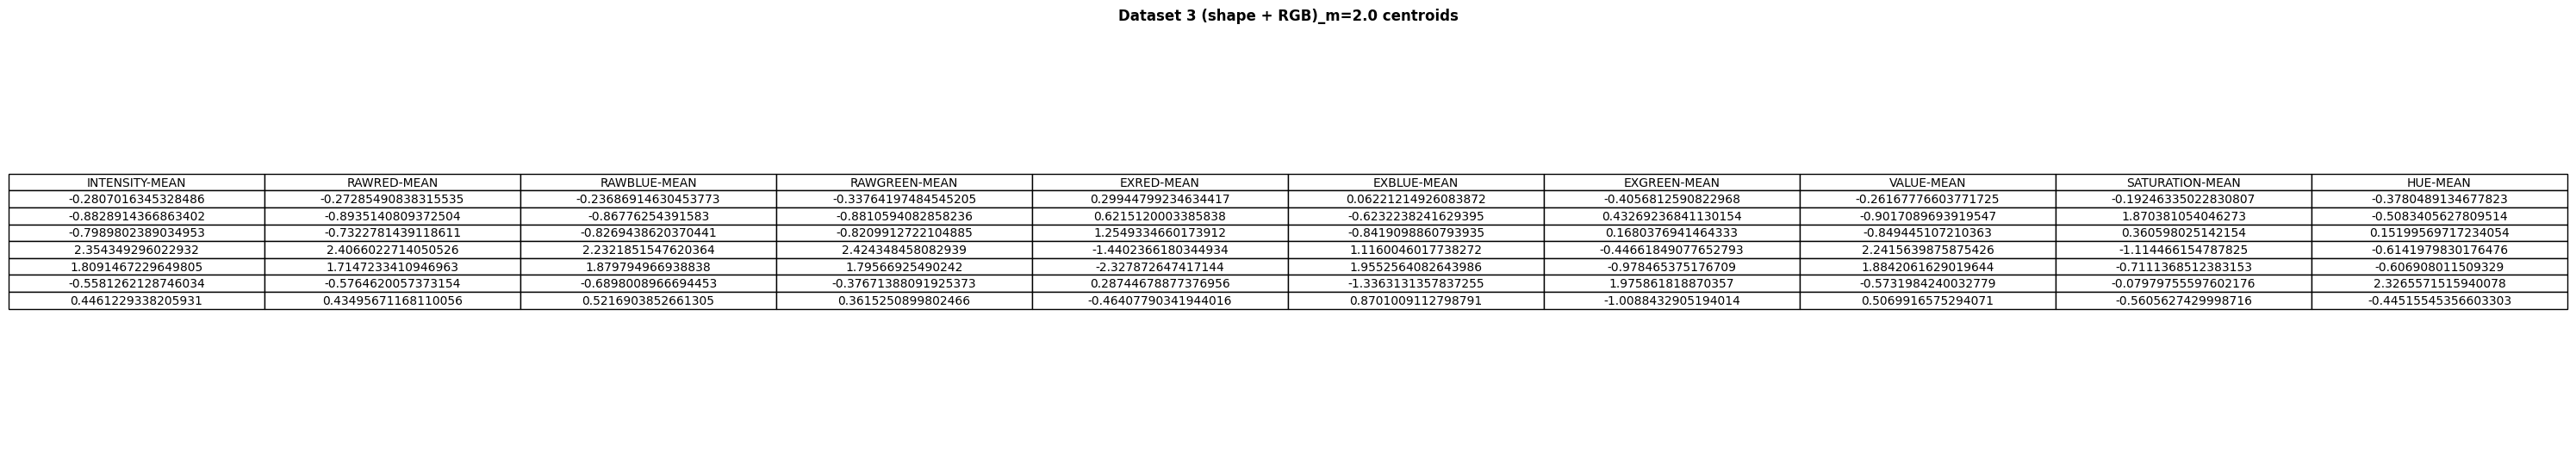



Dataset 3 (shape + RGB)_m=2.0 centroids


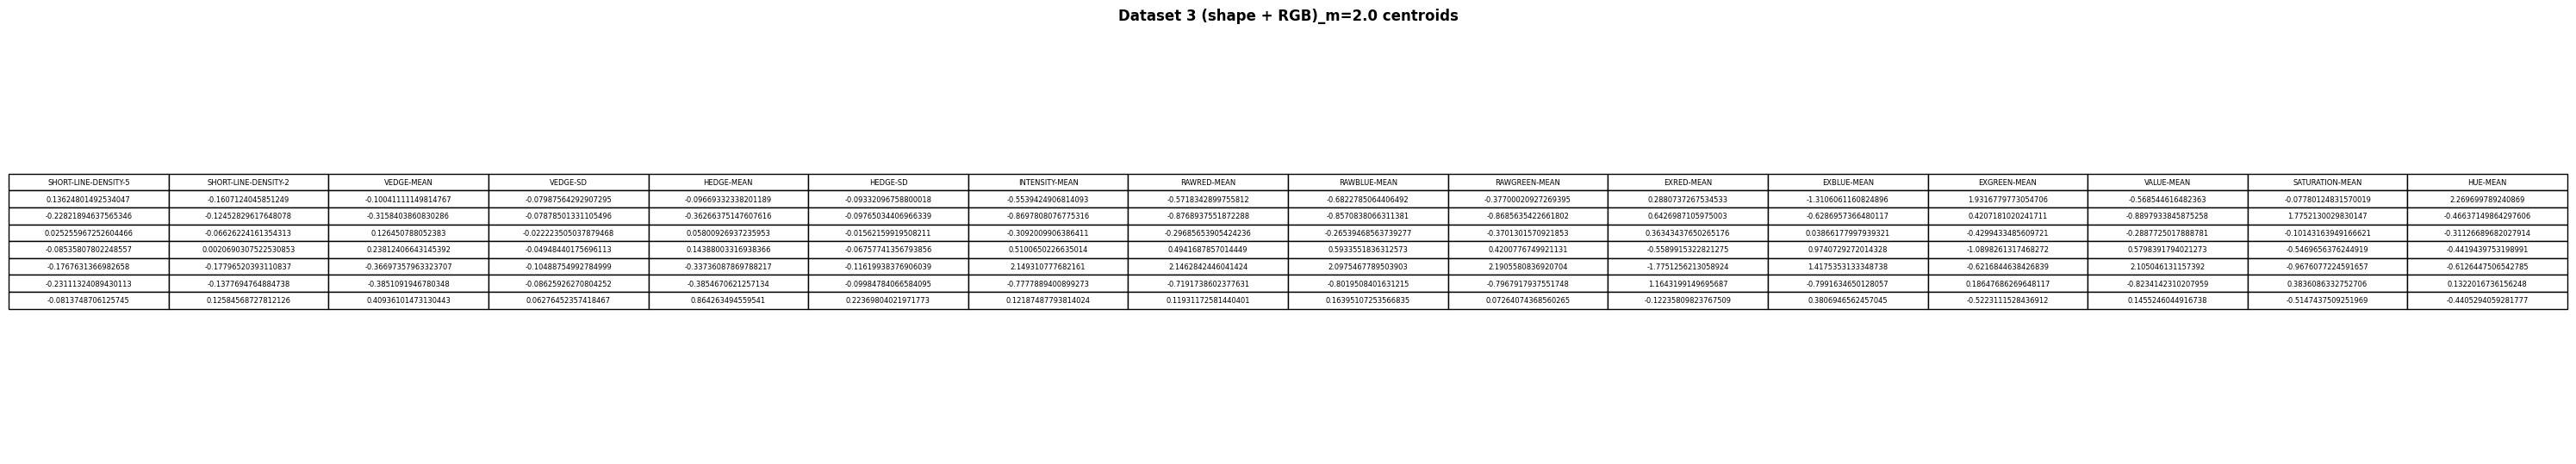

In [27]:
run_show_centroids(save_fig=False, show_plot=True)

## II) A MATRIX DE CONFUSÃO DA PARTIÇÃO CRISP VERSUS A PARTIÇÃO A PRIORI

A MATRIX DE CONFUSÃO DA PARTIÇÃO CRISP VERSUS A PARTIÇÃO A PRIORI ######################################
Confusion matrix: Dataset 1 (shape)_m=2.0 vs a priori


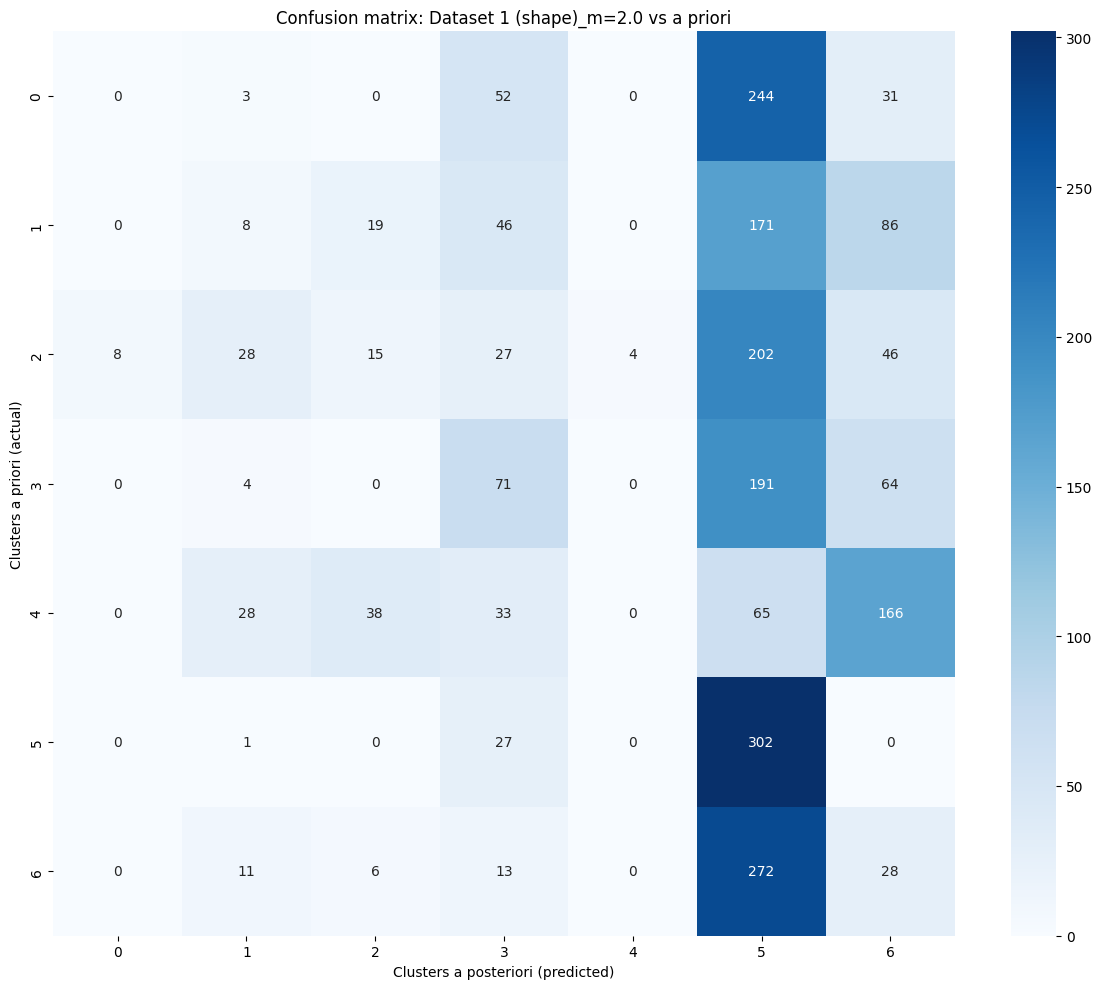



Confusion matrix: Dataset 2 (RGB)_m=2.0 vs a priori


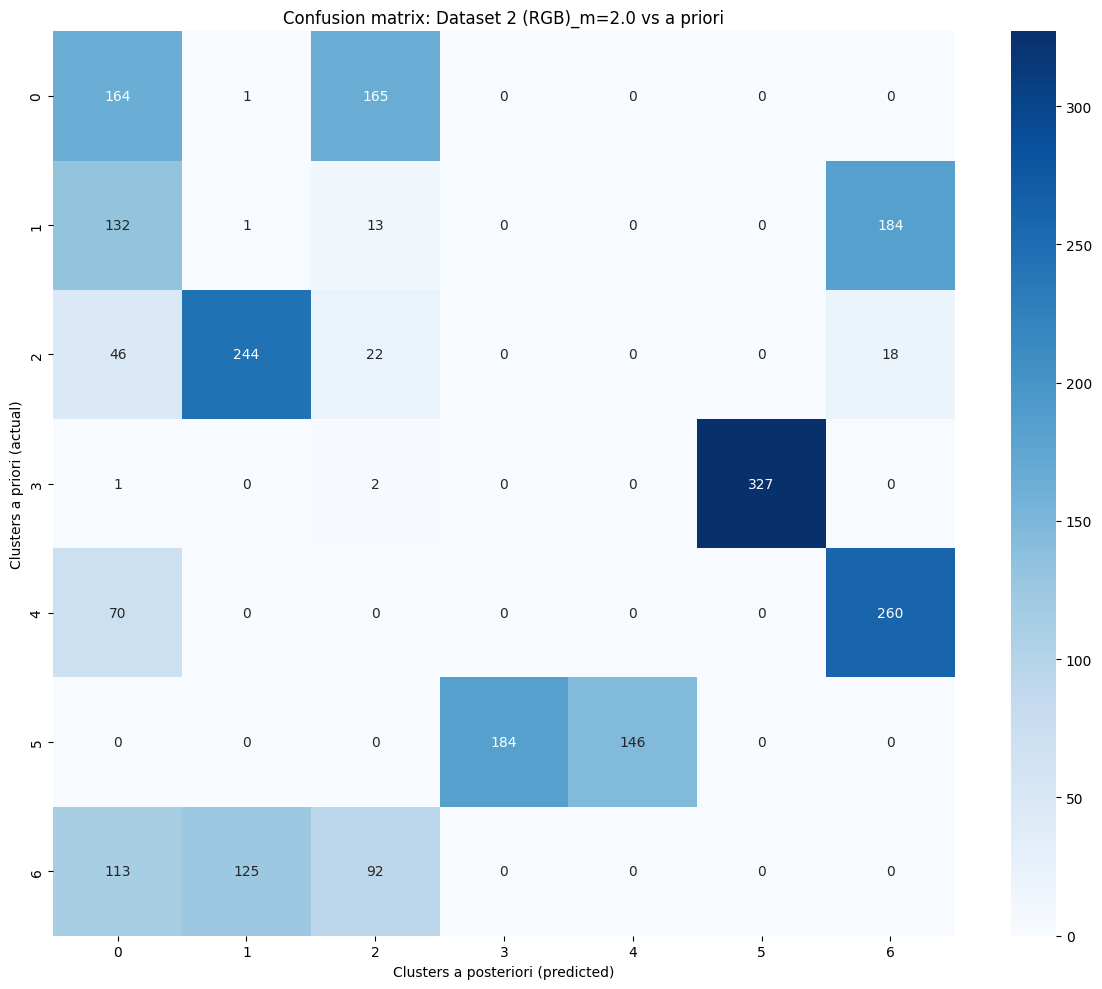



Confusion matrix: Dataset 3 (shape + RGB)_m=2.0 vs a priori


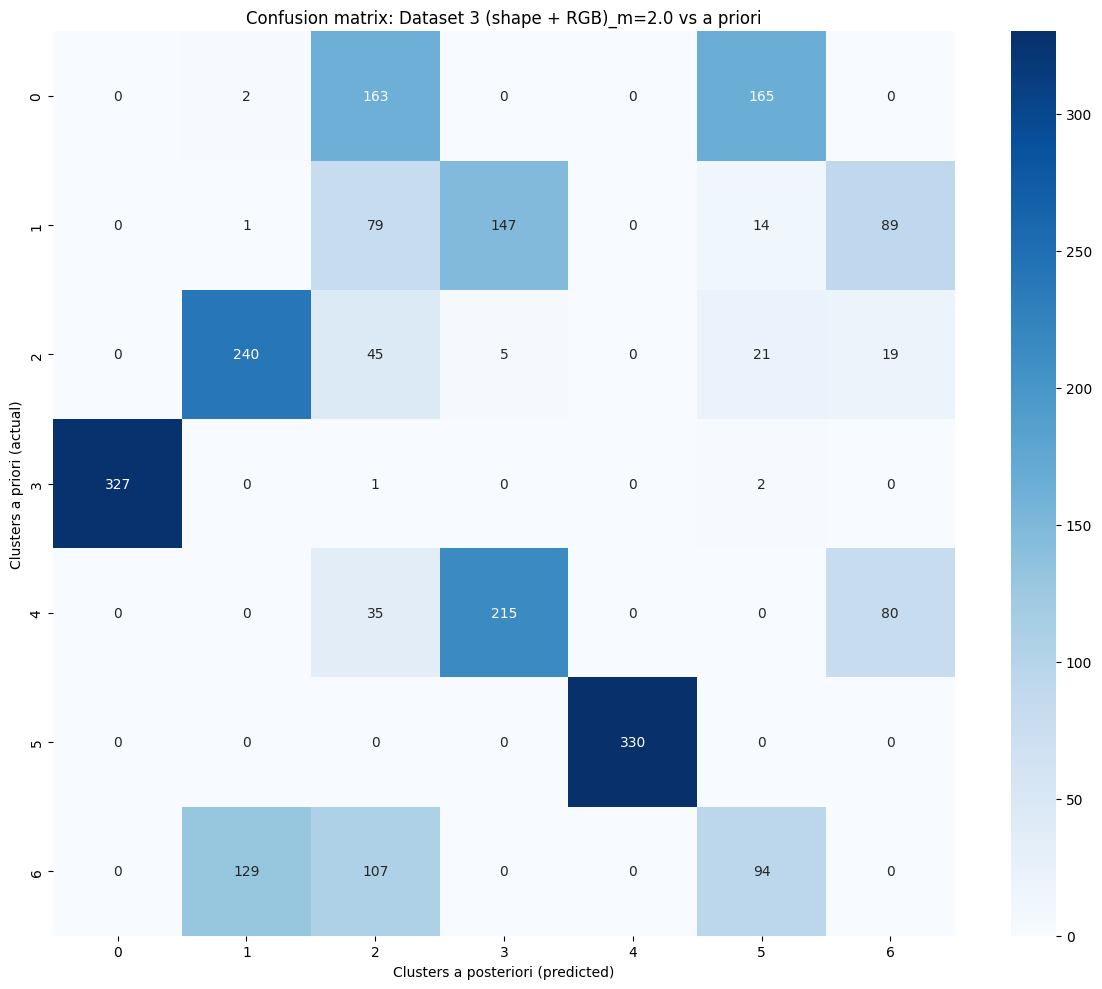

In [28]:
run_show_confusion_matrix_vs_a_priori(save_fig=False, show_plot=True)

## III) A MATRIX DE CONFUSÃO DE UMA PARTIÇÃO CRISP VERSUS A OUTRA;

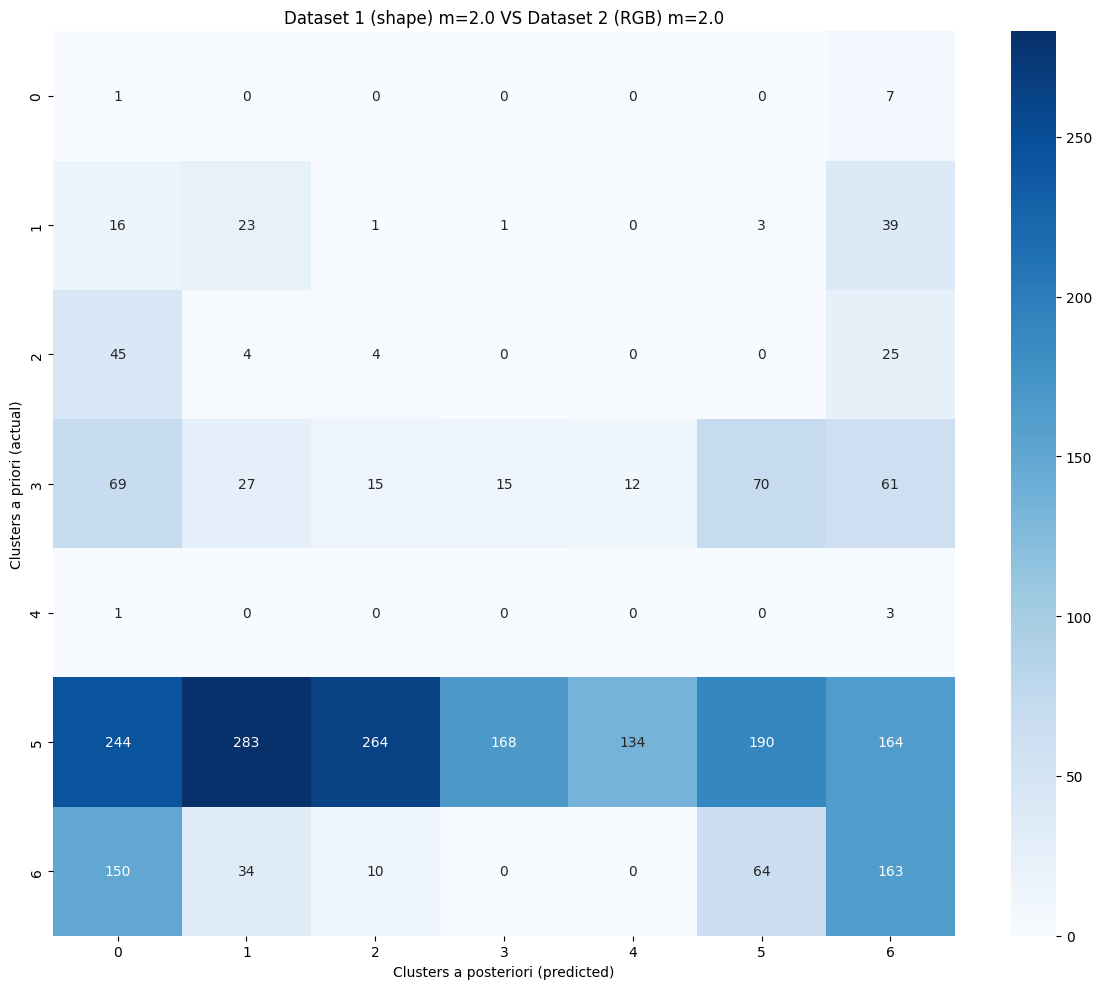

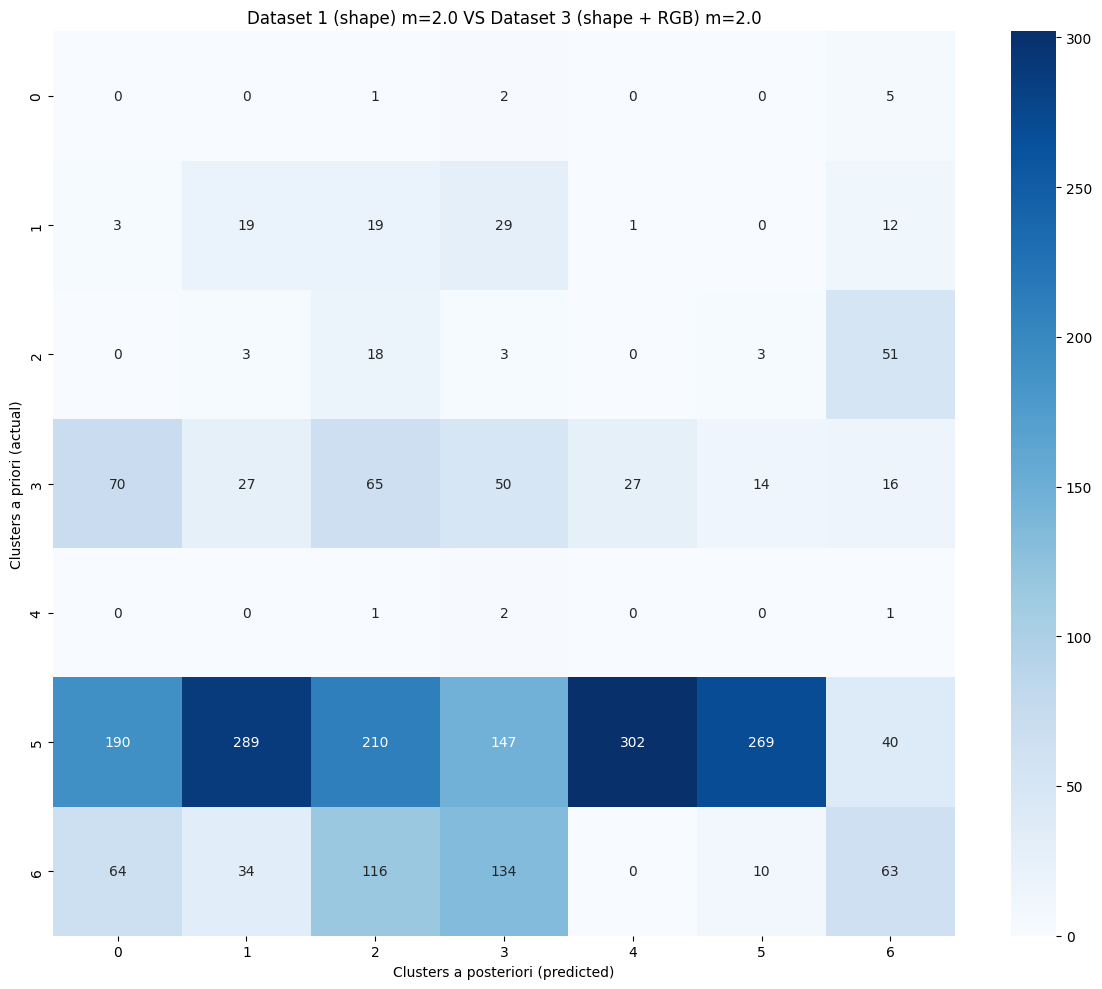

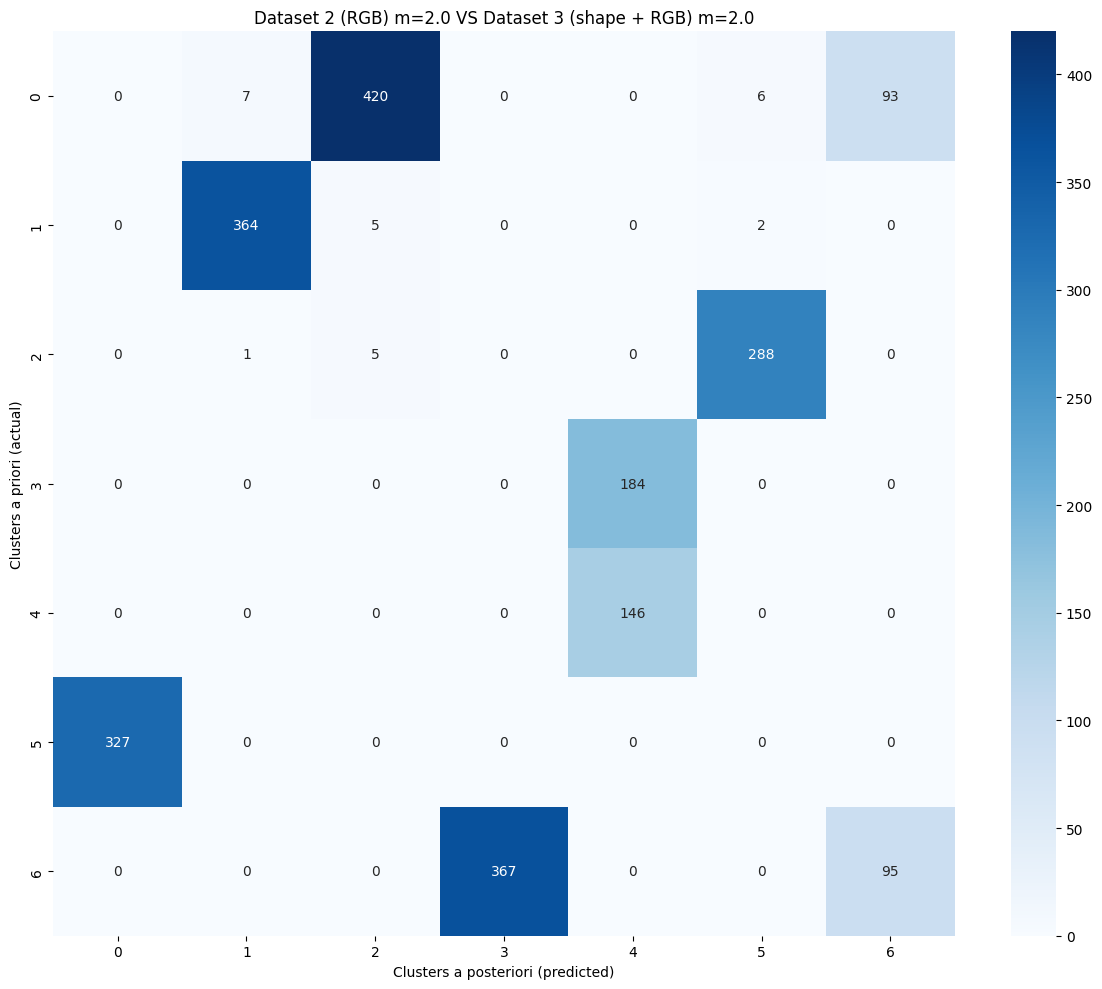

In [29]:
run_show_confusion_matrix_crisp_vs_crisp(best_part_crisp, save_fig=True, show_plot=True)

In [ ]:
assert False

# Fim

In [ ]:
clear()

In [ ]:
n_clusters_C = 7
m_list = [1.1, 1.6, 2.0]
error_e = 0.000001 #10−6
maxiter_T = 100
distance_metric = 'cityblock'
times = 50 #50

run_centroids_confusion_matrix_vs_a_priori(n_clusters_C, m_list, error_e, maxiter_T, distance_metric='cityblock', times=times, save_fig=False, show_plot=True)

In [ ]:
"""iii) a matrix de confusão de
uma partição crisp versus a outra;

dataset 1 m 1.1 vs dataset 1 m 1.1
dataset 1 m 1.1 vs dataset 1 m 1.6
dataset 1 m 1.1 vs dataset 1 m 2.0
dataset 1 m 1.1 vs dataset 2 m 1.1
dataset 1 m 1.1 vs dataset 1 m 1.6
....
dataset 3 m 2.0 vs dataset 3 m 1.1
dataset 3 m 2.0 vs dataset 3 m 1.6
dataset 3 m 2.0 vs dataset 3 m 2.0
"""

In [ ]:
ds_list =  [X_dataset_1, X_dataset_2, X_dataset_3]
m_list =  [1.1, 1.6, 2.0]

run_confusion_matrix_crisp_vs_crisp(ds_list, m_list, save_fig=True, show_plot=True)

In [ ]:
assert False

In [ ]:
"""i) os protótipos (centros de gravidade, centroids)"""

#imprimir com seaborn ou matplot

for i in range(NUMBER_OF_DATASETS):
  print('protótipos da partição ' + str(i + 1) + ':\n')
  print(centroids_matrixes[i], "\n")

In [ ]:
"""
ii) a matrix de confusão da partição crisp versus a partição a priori;
"""

In [ ]:
#Here, each partition's confusion matrix is compared againts the true labels of dataset i.e. 'labels_a_priori' list
for i in range(NUMBER_OF_DATASETS):

  ith_labels_posteriori = datasets_labels_posteriori[i]
  dataset_name = datasets_names[i]

  plot_confusion_matrix(labels_a_priori, ith_labels_posteriori, labels_clusters_names, save_fig=True, dataset_name=dataset_name)

In [ ]:
"""iii) a matrix de confusão de uma partição crisp versus a outra; ???
"""

In [ ]:
"""
Save all result files in DRIVE
"""

In [ ]:
cd '/content/drive/MyDrive/Projeto AM Francisco/resultados_questao_1/m_1.6'

In [ ]:
if EXPERIMENT_MODE:
  new_folder_name = 'm_' + str(m)
  save_result_files_drive(PATH_CONTENT_DRIVE, PATH_DRIVE_RESULTS_FOLDER, new_folder_name = new_folder_name)

In [ ]:
assert False

In [ ]:
clear_content_result_files(PATH_CONTENT_DRIVE)

In [ ]:
#END OF CODE

In [ ]:
assert False

In [ ]:
import os

os.mkdir("allan")

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# centers = [[1, 1], [-1, -1], [1, -1]]
centers = centroids_matrixes[1]
# X, labels_true = make_blobs(
#     n_samples=2310, centers=centers, cluster_std=0.4, random_state=0
# )

# X = StandardScaler().fit_transform(X)

X = X_dataset_2
labels_true = labels_a_priori

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 5], X[:, 7])
plt.show()

In [ ]:
# my dataset
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

# db = DBSCAN(eps=0.3, min_samples=10).fit(X)
# labels = db.labels_
labels = datasets_labels_posteriori[1]

# Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_ = 7
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

In [ ]:
n_noise_

In [ ]:
print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

In [ ]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 5],
        xy[:, 8],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [ ]:
np.max(X_dataset_1[7])

In [ ]:
centroids_matrixes[0]

In [ ]:
#https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [ ]:
labels_clusters_names

In [ ]:

"""ii) a matrix de confusão da partição crisp versus a partição a priori ?"""

#from: https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
#https://scikit-learn.org/stable/modules/clustering.html
#https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1


#for IMAGE SEGMENTATION DATASET
# Creating  a confusion matrix,which compares the y_test and y_pred
labels_posteriori = datasets_labels_posteriori[1]

cm = confusion_matrix(labels_a_priori, labels_posteriori)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
mylist = list(labels_clusters_names)
cm_df = pd.DataFrame(cm,
                     index = list(labels_clusters_names),
                     columns = list(labels_clusters_names))
#Plotting the confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Clusters a priori (actual)')
plt.xlabel('Clusters a posteriori (predicted)')
plt.show()

## More code

In [ ]:
#data = X_dataset_1
n_clusters_C = 7
m = 2 #{1.1; 1.6; 2.0}. 1.1 resuls on error: RuntimeWarning: overflow encountered in exp AND invalid value encountered in true_divide. USE OTHER IMPL OF FCM
distance_metric = 'cityblock'
error_e=0.000001
maxiter_T=100
best_objective_value = 99999999999.9
best_results = 0
times = 1 #50



datasets = [X_dataset_1, X_dataset_2, X_dataset_3]

In [ ]:
# centroids, U, iter = fuzzy_cmeans(X_dataset_1, n_clusters_C, m, distance_metric = 'cityblock')

cntr, u, u0, d, jm, p, fpc = skfuzzy_fcm(X_dataset_1.T, n_clusters_C, m, error_e, maxiter_T, distance_metric)
centroids2, U, iter2, objective_functions = cntr, u, p, jm
U

In [ ]:
U[:,0], U.shape

In [ ]:
#verificando validade do cálculo. OK
C = 7
sum = 0
for i in range(C):

  sum += U[i][0]

sum

In [ ]:
np.unique(preds)

In [ ]:
#https://www.youtube.com/watch?v=zEYxTGDYWYI (ok)
#MORE ON: https://scikit-fuzzy.readthedocs.io/en/latest/auto_examples/plot_cmeans.html

In [ ]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Generate test data
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

In [ ]:
alldata.shape

In [ ]:
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

In [ ]:
#objective_value = calculate_objective(X_dataset_1, centroids, U, m, distance_metric)
objective_value = calculate_objective(X_dataset_1.T, centroids, U, m, distance_metric)
objective_value

In [ ]:
X_dataset_1.T.shape

In [ ]:
import numpy as np
import skfuzzy as fuzz
from scipy.spatial.distance import cdist

# Generate some random data
#data = np.random.rand(100, 2)

# Set the number of clusters
num_clusters = 3

# Apply city-block (Manhattan) distance effect
data_city_block = cdist(data, data, metric='cityblock') #euclidean, cosine

# Perform Fuzzy C-means clustering
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_city_block.T,
    num_clusters,
    2,
    error=0.005,
    maxiter=1000
)

# The 'u' matrix contains the fuzzy membership values for each data point

# Print the cluster centers
print("Cluster centers:")
print(cntr)

# Print the fuzzy membership values for the first data point
print("Fuzzy membership values for data point 0:")
print(u[:, 0])


In [ ]:

import numpy as np
import skfuzzy as fuzz
from scipy.spatial.distance import cdist

# Set the random seed for reproducibility
RANDOM_SEED=42

np.random.seed(RANDOM_SEED)

# Generate some random data
data = np.random.rand(100, 2)

# Set the number of clusters
num_clusters = 3

# Apply city-block (Manhattan) distance effect
data_city_block = cdist(data, data, metric='cityblock') #cityblock, euclidean, cosine

# Set the random seed for numpy.random
np.random.seed(RANDOM_SEED)

# Perform Fuzzy C-means clustering
# cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_city_block.T,
    num_clusters,
    m=2,
    error=0.005,
    maxiter=1000
)

# The 'u' matrix contains the fuzzy membership values for each data point

return_func = cntr, u, p

# Print the cluster centers
print("Cluster centers:")
print(cntr)

# Print the fuzzy membership values for the first data point
print("Fuzzy membership values for data point 0:")
print(u[:, 0])



In [ ]:
u.shape

In [ ]:
u

In [ ]:
u_T = u.T
u_T.shape

In [ ]:
u_T

In [ ]:
u_T[0][0] + u_T[0][1] + u_T[0][2]

In [ ]:
#https://pyclustering.github.io/docs/0.10.1/html/d2/d6a/classpyclustering_1_1cluster_1_1fcm_1_1fcm.html

In [ ]:
!pip3 install pyclustering

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm
from pyclustering.utils import read_sample

# load list of points for cluster analysis
#sample = read_sample(FAMOUS_SAMPLES.SAMPLE_OLD_FAITHFUL)
sample = X_dataset_1
# initialize
initial_centers = kmeans_plusplus_initializer(sample, 7, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()

# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(sample, initial_centers)

# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

# visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, marker='*', markersize=10)
visualizer.show()

In [ ]:
len(clusters), type(clusters), type(clusters[0])

In [ ]:
len(clusters[0])

In [ ]:
len(centers)

In [ ]:
#verificar se soma de probabilidades para cada cluster resulta em 1
e = 1
sum = 0
for i in range(n_clusters_C):

  sum += membership_matrixes[0][i][e]

sum

In [ ]:
labels_posteriori = datasets_labels_posteriori[2]

s=100
X = X_dataset_2
plt.scatter(X[labels_posteriori == 0, 0], X[labels_posteriori == 0, 1], s=s, c='red', label='Cluster 0')
plt.scatter(X[labels_posteriori == 1, 0], X[labels_posteriori == 1, 1], s=s, c='orange', label='Cluster 1')
plt.scatter(X[labels_posteriori == 2, 0], X[labels_posteriori == 2, 1], s=s, c='green', label='Cluster 2')
plt.scatter(X[labels_posteriori == 3, 0], X[labels_posteriori == 3, 1], s=s, c='blue', label='Cluster 3')
plt.scatter(X[labels_posteriori == 4, 0], X[labels_posteriori == 4, 1], s=s, c='violet', label='Cluster 4')
plt.scatter(X[labels_posteriori == 5, 0], X[labels_posteriori == 5, 1], s=s, c='darkviolet', label='Cluster 5')
plt.scatter(X[labels_posteriori == 6, 0], X[labels_posteriori == 6, 1], s=s, c='darkgoldenrod', label='Cluster 6')

plt.xlabel('label 0')
plt.ylabel('label 1')
plt.legend()

In [ ]:
cntr, u, u0, d, jm, p, fpc = skfuzzy_fcm(X_dataset_1, n_clusters_C, m, error_e, maxiter_T, distance_metric)
cntr.shape, u.shape

In [ ]:
alldata =  X_dataset_2.T

In [ ]:
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 7, 1.6, error=0.005, maxiter=100)
cntr.shape

In [ ]:
u_orig.shape

In [ ]:
u_orig.argmax(axis=0)

In [ ]:
X_dataset_2.shape

In [ ]:
dataset_1_np = dataset_1.to_numpy()
np.max(dataset_1_np)

In [ ]:
#pre-processing of dataset
X_dataset_1 = preprocess_dataset(dataset_1)
np.max(X_dataset_1, axis=1)

In [ ]:
#labels a priori
data = X_dataset_2.T
indexColumnA = 5
indexColumnB = 7
labels = labels_a_priori

plot_scatter_two_features(data, labels, indexColumnA, indexColumnB, save_fig=False, dataset_name='dataset_2')

labels = datasets_labels_posteriori[2]

plot_scatter_two_features(data, labels, indexColumnA, indexColumnB, save_fig=False, dataset_name='dataset_2')

In [ ]:
data = X_dataset_2
dataset_name = 'dataset_2'
# labels = labels_a_priori
labels = datasets_labels_posteriori[1]
save_fig=True

feat_x_index = 4
feat_y_index = 5
feat_z_index = 7

plot_scatter_three_features(data, labels, fetures_indexes_list=[feat_x_index, feat_y_index, feat_z_index], save_fig=True, dataset_name='dataset')

In [ ]:
#verifying scaler

#pre-processing of dataset
scaler = StandardScaler()
data = scaler.fit_transform(dataset_1.values)
asc = np.sort(data)
des_rev = np.flip(asc)
asc, des_rev

In [ ]:
#I want to print centroids and its groups
#.não faz muito sentido, depende das dimensões

#https://scikit-fuzzy.readthedocs.io/en/latest/auto_examples/plot_cmeans.html
#https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

X= -2 * np.random.rand(100,2)
X1 = 1 + 2 * np.random.rand(50,2)
X[50:100, :] = X1 #divisao entre grupos
plt.scatter(X[ : , 0], X[ :, 1], s = 50, c = 'b')
plt.show()

from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)
Kmean.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
  n_clusters=3, n_init=10, random_state=None, tol=0.0001, verbose=0)

In [ ]:
centroids = Kmean.cluster_centers_
centroids

In [ ]:
centroids[0][0]

In [ ]:
plt.scatter(X[ : , 0], X[ : , 1], s =50, c='b')
plt.scatter( 2.19934167,  1.39012626, s=200, c='g', marker='s')
plt.scatter(-1.01823807, -1.04679272, s=200, c='r', marker='s')
plt.scatter(1.89683623, 2.49427892, s=200, c='y', marker='s')

In [ ]:
centroids_matrixes[1]

In [ ]:
centroids_matrixes[1][0,:]

In [ ]:
feat_index_a = 0
feat_index_b = 1
cen_feats = centroids_matrixes[1][[feat_index_a, feat_index_b],:]
cen_feats

In [ ]:
cen_feats[0]

In [ ]:
#pra meus dados
X = X_dataset_2


plt.scatter(X[ : , 0], X[ : , 1], s =50, c='b')
plt.scatter( 2.19934167,  1.39012626, s=200, c='g', marker='s')
plt.scatter(-1.01823807, -1.04679272, s=200, c='r', marker='s')
plt.scatter(1.89683623, 2.49427892, s=200, c='y', marker='s')

In [ ]:
centroids_matrixes[1]

In [ ]:
X = X_dataset_2


In [ ]:
feat5 = centroids_matrixes[1][:,5]
feat5 = tuple(feat5)
feat5

In [ ]:
feat7 = centroids_matrixes[1][:,7]
feat7 = tuple(feat7)
feat7

In [ ]:
array=np.array([[-0.94665068, -0.97138368],
 [ 2.01559419, 2.02597093]])
array

In [ ]:
plt.scatter(X[ : , 5], X[ : , 7], s =50, c='b')
plt.scatter(-0.94665068, -0.97138368, s=200, c='g', marker='s')
plt.scatter( 2.01559419,  2.02597093, s=200, c='r', marker='s')
plt.show()

In [ ]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

plt.scatter(X[:, 5], X[:, 7])
plt.show()

In [ ]:
#axis=0. running VERTICALLY downwards across rows (axis 0). OPERA (sum, max..) NA COLUNA, PERCORRENDO AS LINHAS
#axis=1. running HORIZONTALLY across columns (axis 1). OPERA (sum, max..) NA LINHA, PERCORRENDO AS COLUNAS

In [ ]:
#EXTRA: just to see
label_names = labels_clusters_names

for i in range(NUMBER_OF_DATASETS):

  filename = 'dataset_'+ str(i + 1) + '_CRISP_pie_chart'
  ith_crisp_partition = crisp_partitions[i]
  pie_plot_crisp_partition(ith_crisp_partition, label_names, filename)